# Informe Accidentalidad - Barranquilla

### Descargamos e importamos instancias necesarias

In [ ]:
%pip install sodapy
%pip install geopy
%pip install folium
import pandas as pd
from sodapy import Socrata
import requests
from geopy.geocoders import Nominatim
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt

# Configuración de no truncar visualización de los DF.
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

### Obtenemos los datos de: https://www.datos.gov.co/Transporte/Accidentalidad-en-Barranquilla/yb9r-2dsi/about_data

In [29]:
client = Socrata("www.datos.gov.co", None)
results = client.get("yb9r-2dsi", limit=50000)
results_df = pd.DataFrame.from_records(results)

In [30]:
results_df = results_df.map(lambda x: x.lower() if isinstance(x, str) else x)
meses_a_numeros = {
    'enero': 1,
    'febrero': 2,
    'marzo': 3,
    'abril': 4,
    'mayo': 5,
    'junio': 6,
    'julio': 7,
    'agosto': 8,
    'septiembre': 9,
    'octubre': 10,
    'noviembre': 11,
    'diciembre': 12
}
results_df['mes_accidente'] = results_df['mes_accidente'].replace(meses_a_numeros).astype(str)
results_df['hora_accidente'] = pd.to_datetime(results_df['hora_accidente'], format='%I:%M:%S:%p')
results_df['fecha_accidente'] = pd.to_datetime(results_df['fecha_accidente'], format='mixed').dt.date
results_df['cant_heridos_en_sitio_accidente'] = results_df['cant_heridos_en_sitio_accidente'].fillna(0)


### A partir de aquí, hacemos un analisis descriptivo de nuestros datos generales de accidentalidad en la ciudad de Barranquilla.

In [33]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24731 entries, 0 to 24730
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   fecha_accidente                  24731 non-null  object        
 1   a_o_accidente                    24731 non-null  object        
 2   mes_accidente                    24731 non-null  object        
 3   dia_accidente                    24731 non-null  object        
 4   hora_accidente                   24731 non-null  datetime64[ns]
 5   gravedad_accidente               24731 non-null  object        
 6   clase_accidente                  24731 non-null  object        
 7   sitio_exacto_accidente           24731 non-null  object        
 8   cant_heridos_en_sitio_accidente  24731 non-null  object        
 9   cantidad_accidentes              24731 non-null  object        
 10  cant_muertos_en_sitio_accidente  228 non-null    object   

#### Aquí podemos encontrar datos interesantes como por ejemplo:

1. El año en que se presentarón mas accidentes fue 2018, con un total de 5898.
2. El mes donde generalmente se presentan mas accidentes es febreo, con un total de 2347.
3. La ubicación de la ciudad con mas accidentes desde 2018 hasta agosto de 2023 fue CL 110 CR 9G.

In [39]:
description_df = results_df.describe(include='all')
description_df = description_df.loc[['count', 'unique', 'top', 'freq']]
description_df

,fecha_accidente,a_o_accidente,mes_accidente,dia_accidente,hora_accidente,gravedad_accidente,clase_accidente,sitio_exacto_accidente,cant_heridos_en_sitio_accidente,cantidad_accidentes,cant_muertos_en_sitio_accidente
count,24731,24731,24731,24731,24731,24731,24731,24731,24731.0,24731,228
unique,2149,6,12,7,NaN,3,6,14815,24.0,2,2
top,2018-08-06,2018,2,tue,NaN,solo daños,choque,cl 110 cr 9g,0.0,1,1
freq,34,5898,2347,3883,NaN,15456,23099,77,15608.0,24726,221


#### Apartir de aquí, tenemos graficas como parte de nuestro analisis descriptivo de ciertas variables importantes

##### Con este siguiente grafico podemos ver que el año en el que se presentaron mas accidentes fue en 2018. Además, podemos ver un bajo numero de accidentes en el año 2023 con respecto a los años anteriores. 

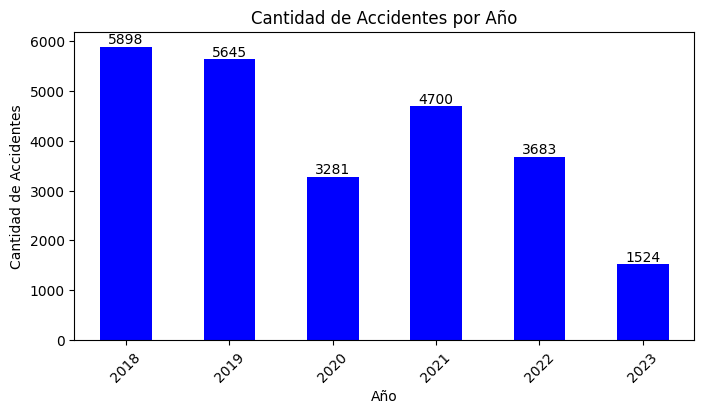

In [40]:
accidentes_por_año = results_df['a_o_accidente'].value_counts().sort_index()

plt.figure(figsize=(8, 4))
bar_one = accidentes_por_año.plot.bar(x=accidentes_por_año.index, y=accidentes_por_año.values, color='blue')
plt.title('Cantidad de Accidentes por Año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Accidentes')
plt.xticks(rotation=45)
for i, valor in enumerate(accidentes_por_año.values):
    bar_one.text(i, valor + 0.2, str(valor), ha='center', va='bottom')
plt.show()

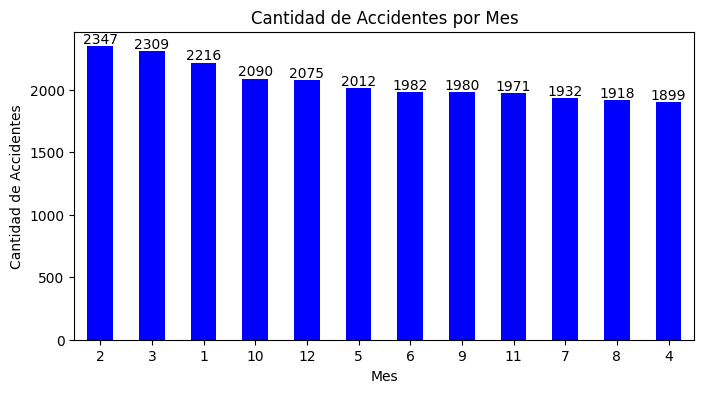

In [41]:
df_accidentes_por_mes = results_df['mes_accidente'].value_counts()
df_accidentes_por_mes.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(8, 4))
bar_three = df_accidentes_por_mes.plot.bar(x=df_accidentes_por_mes.index, y=df_accidentes_por_mes.values, color='blue')
plt.title('Cantidad de Accidentes por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Accidentes')
plt.xticks(rotation=0)
for i, valor in enumerate(df_accidentes_por_mes.values):
    bar_three.text(i, valor + 0.2, str(valor), ha='center', va='bottom')
plt.show()

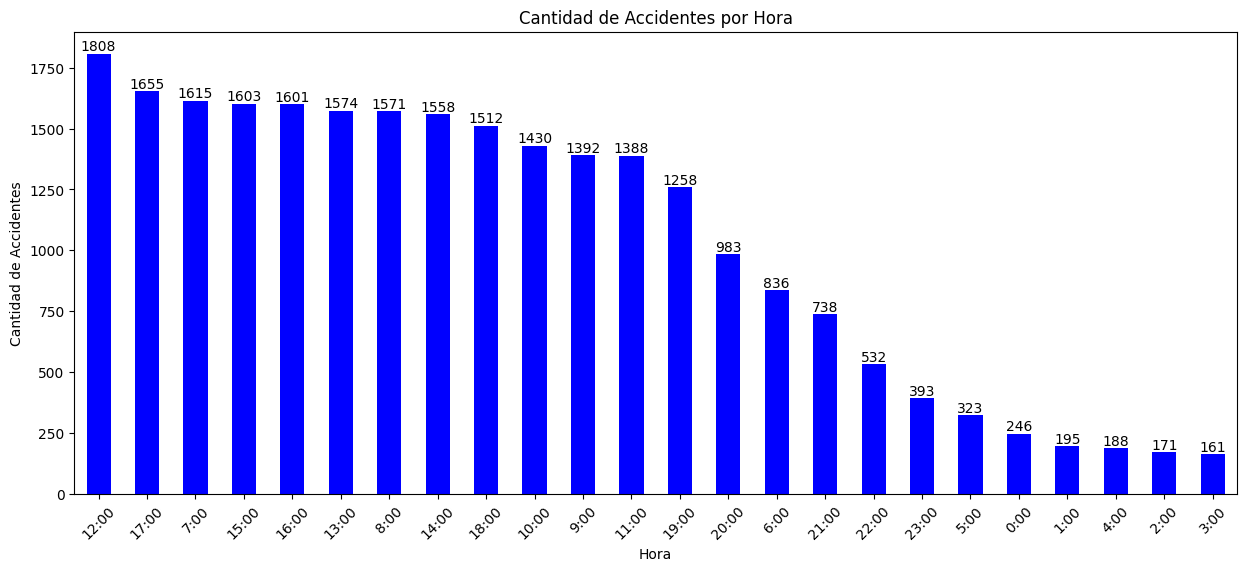

In [42]:
df_agrupado_por_hora = results_df.groupby(results_df['hora_accidente'].dt.hour).size()
df_agrupado_por_hora.index = df_agrupado_por_hora.index.astype(str) + ':00'
df_agrupado_por_hora.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(15, 6))
bar_three = df_agrupado_por_hora.plot.bar(x=df_agrupado_por_hora.index, y=df_agrupado_por_hora.values, color='blue')
plt.title('Cantidad de Accidentes por Hora')
plt.xlabel('Hora')
plt.ylabel('Cantidad de Accidentes')
plt.xticks(rotation=45)
for i, valor in enumerate(df_agrupado_por_hora.values):
    bar_three.text(i, valor + 0.2, str(valor), ha='center', va='bottom')
plt.show()


### Ahora, a partir de aquí, queremos hacer un analisis de estos datos de accidentalidad en este año 2023.

In [46]:
df_2023 = results_df[results_df["a_o_accidente"] == "2023"]
df_2023 = df_2023.set_index(pd.RangeIndex(len(df_2023.index)))

In [47]:
df_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1524 entries, 0 to 1523
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   fecha_accidente                  1524 non-null   object        
 1   a_o_accidente                    1524 non-null   object        
 2   mes_accidente                    1524 non-null   object        
 3   dia_accidente                    1524 non-null   object        
 4   hora_accidente                   1524 non-null   datetime64[ns]
 5   gravedad_accidente               1524 non-null   object        
 6   clase_accidente                  1524 non-null   object        
 7   sitio_exacto_accidente           1524 non-null   object        
 8   cant_heridos_en_sitio_accidente  1524 non-null   object        
 9   cantidad_accidentes              1524 non-null   object        
 10  cant_muertos_en_sitio_accidente  42 non-null     object     

In [50]:
description_df_2023 = df_2023.describe(include='all')
description_df_2023 = description_df_2023.loc[['count', 'unique', 'top', 'freq']]
description_df_2023

,fecha_accidente,a_o_accidente,mes_accidente,dia_accidente,hora_accidente,gravedad_accidente,clase_accidente,sitio_exacto_accidente,cant_heridos_en_sitio_accidente,cantidad_accidentes,cant_muertos_en_sitio_accidente
count,1524,1524,1524,1524,1524,1524,1524,1524,1524,1524,42
unique,330,1,11,7,NaN,3,6,1376,16,1,1
top,2023-06-05,2023,2,sun,NaN,con heridos,choque,calle 110 carrera 43,1,1,1
freq,13,1524,158,227,NaN,1475,1285,8,973,1524,42


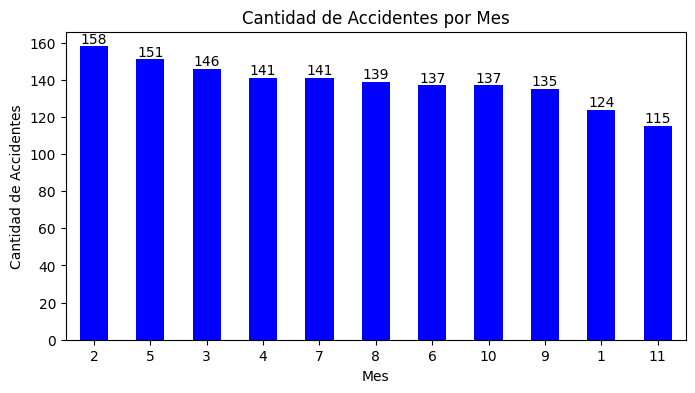

In [51]:
df_2023_por_meses = df_2023['mes_accidente'].value_counts()
df_2023_por_meses.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(8, 4))
bar_four = df_2023_por_meses.plot.bar(x=df_2023_por_meses.index, y=df_2023_por_meses.values, color='blue')
plt.title('Cantidad de Accidentes por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Accidentes')
plt.xticks(rotation=0)
for i, valor in enumerate(df_2023_por_meses.values):
    bar_four.text(i, valor + 0.2, str(valor), ha='center', va='bottom')
plt.show()

In [19]:
fechas_mes_con_mas_accidentes = results_df[(results_df['fecha_accidente'] >= pd.to_datetime('2023-02-17').date()) & (results_df['fecha_accidente'] <= pd.to_datetime('2023-02-21').date())]
fechas_mes_con_mas_accidentes.count()

fecha_accidente                    34
a_o_accidente                      34
mes_accidente                      34
dia_accidente                      34
hora_accidente                     34
gravedad_accidente                 34
clase_accidente                    34
sitio_exacto_accidente             34
cant_heridos_en_sitio_accidente    34
cantidad_accidentes                34
cant_muertos_en_sitio_accidente     1
dtype: int64

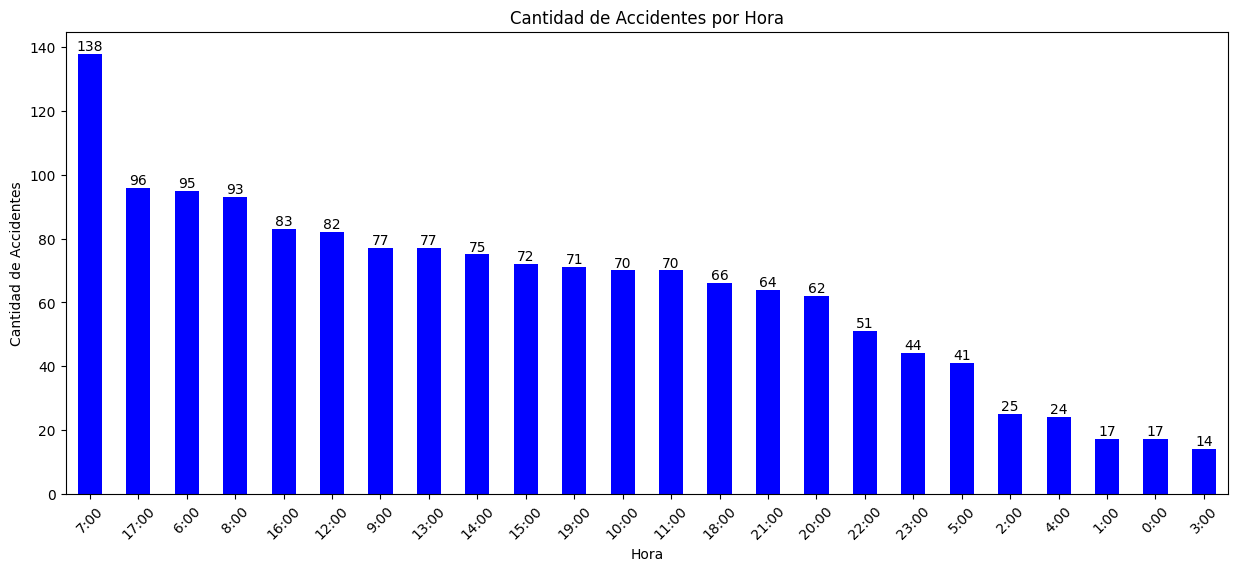

In [62]:
df_2023_por_horas = df_2023.groupby(df_2023['hora_accidente'].dt.hour).size()
df_2023_por_horas.index = df_2023_por_horas.index.astype(str) + ':00'
df_2023_por_horas.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(15, 6))
bar_five = df_2023_por_horas.plot.bar(x=df_2023_por_horas.index, y=df_2023_por_horas.values, color='blue')
plt.title('Cantidad de Accidentes por Hora')
plt.xlabel('Hora')
plt.ylabel('Cantidad de Accidentes')
plt.xticks(rotation=45)
for i, valor in enumerate(df_2023_por_horas.values):
    bar_five.text(i, valor + 0.2, str(valor), ha='center', va='bottom')
plt.show()

In [61]:
# Función para obtener la latitud y longitud de una dirección con Geopy
def obtener_latitud_longitud_geopy(direccion):
    geolocator = Nominatim(user_agent="my_geocoder")
    try:
        location = geolocator.geocode(direccion, timeout=10)
    except Exception as e:
        print(f"Error en la solicitud Geopy: {e}")
        location = None

    if location:
        latitud = location.latitude
        longitud = location.longitude
        return latitud, longitud
    else:
        return None, None

# Función para obtener la latitud y longitud de una dirección con Azure Maps
def obtener_latitud_longitud_azure(direccion):
    
    url = f"https://atlas.microsoft.com/search/address/json?api-version=1.0&subscription-key={'API_KEY'}&query={direccion}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        if data.get('results'):
            location = data['results'][0]['position']
            return location['lat'], location['lon']

    # Devuelve valores predeterminados si no se encuentra la ubicación
    return None, None

def obtener_latitud_longitud(direccion):
    latitud, longitud = obtener_latitud_longitud_geopy(direccion)

    if latitud is None or longitud is None:
        latitud, longitud = obtener_latitud_longitud_azure(direccion)

    return latitud, longitud

In [63]:
latlong = []
# Iterar sobre las direcciones y obtener latitud y longitud
for direccion in df_2023['sitio_exacto_accidente']:
    latitud, longitud = obtener_latitud_longitud_azure(f"{direccion}, Barranquilla, Atlántico, Colombia")
    latlong.append({'Latitud': latitud, 'Longitud': longitud})

# Crear un DF con las latitudes y longitudes
latlong_df = pd.DataFrame(latlong)
# Guardar el DF en un archivo CSV
latlong_df.to_csv('coordenadas_accidentes_bquilla_2023_azure.csv')

In [65]:
df_accidentes_2023_ubicacion = pd.concat([df_2023, pd.read_csv('coordenadas_accidentes_bquilla_2023_azure.csv')], axis=1)

In [66]:
df_accidentes_2023_ubicacion.dropna(subset=['Latitud', 'Longitud'], inplace=True)
df_accidentes_2023_ubicacion.to_csv('accidentes_bquilla_2023_ubicacion_fulldataset.csv')
print(f"Dimensiones del DF: {df_accidentes_2023_ubicacion.shape}")

Dimensiones del DF: (1524, 14)


In [67]:
lat_min, lat_max = 10.8, 11.1
lon_min, lon_max = -75.0, -74.5

geoinfo_area_metropolitana_quilla = df_accidentes_2023_ubicacion[
    (df_accidentes_2023_ubicacion['Latitud'] >= lat_min) & (df_accidentes_2023_ubicacion['Latitud'] <= lat_max) &
    (df_accidentes_2023_ubicacion['Longitud'] >= lon_min) & (df_accidentes_2023_ubicacion['Longitud'] <= lon_max)
]

print(f"Dimensiones del DF: {geoinfo_area_metropolitana_quilla.shape}")

Dimensiones del DF: (1400, 14)


In [68]:
# Crea un objeto gmplot centrado en las coordenadas promedio
barranquilla_map = folium.Map(location=[geoinfo_area_metropolitana_quilla['Latitud'].iloc[0], geoinfo_area_metropolitana_quilla['Longitud'].iloc[0]], zoom_start=13)

# Agrega marcadores para cada accidente en el DataFrame
for index, row in geoinfo_area_metropolitana_quilla.iterrows():
    popup_text = f"Fecha: {row['fecha_accidente']}<br/> Hora: {row['hora_accidente']}<br/>Dirección: {row['sitio_exacto_accidente']}<br/>Heridos: {row['cant_heridos_en_sitio_accidente']}"
    folium.Marker(location=[row['Latitud'], row['Longitud']], popup=popup_text).add_to(barranquilla_map)

# Mostrar el mapa
barranquilla_map

In [69]:
mapa_cluster = folium.Map(location=[geoinfo_area_metropolitana_quilla['Latitud'].iloc[0], geoinfo_area_metropolitana_quilla['Longitud'].iloc[0]], zoom_start=12)
marker_cluster = MarkerCluster().add_to(mapa_cluster)

for index, row in geoinfo_area_metropolitana_quilla.iterrows():
    popup_text = f"Fecha: {row['fecha_accidente']}<br/> Hora: {row['hora_accidente']}<br/>Dirección: {row['sitio_exacto_accidente']}<br/>Heridos: {row['cant_heridos_en_sitio_accidente']}"
    folium.Marker(location=[row['Latitud'],  row['Longitud']], popup=popup_text).add_to(marker_cluster)

mapa_cluster